# Case Study 2 - Predict the success of a product 

 **1. Data Preparation**  
  1.1 Exploration  
  . . 1.1.1 Imports, functions and load dataset  
  . . 1.1.2 Exploring the dataset using pandas profiler  
  . . 1.1.3 Understanding and encoding the target variable  
  . . 1.1.4 Insights  
  1.2. Data Preprocessing  
  . . 1.2.1 Data Type conversions  
  . . 1.2.2 Group variables by data type and set the list of removals  
  . . 1.2.3 Check cardinality  
  . . 1.2.4 Variable populations  
  . . 1.2.5 Detect correlated features  
  . . 1.2.6 Summarize variable removals and drop  
  . . 1.2.7 Train/test sampling  
  . . 1.2.8 Undersampling the majority class  
  . . 1.2.9 One hot encoding  
  **2. Modeling**  
  2.1. Regression  
  . . 2.1.1 CatBoost Regressor  
  . . 2.1.2 XGBoost Regressor  
  2.2 Classification  
  . . 2.2.1 CatBoost Classifier  
  . . 2.2.2 XGBoost Classifier  
  2.3 Model results  
  **3. Predictions**  
  3.1. Top predictions  
  3.2. Trends

# 1.Data Preparation
## 1 Exploration

### 1.1.1 Imports, functions and load dataset

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import xgboost
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from scipy.stats import norm, skew
from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from pandasql import sqldf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, classification_report, log_loss #For classification
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score #For regression
from sklearn.utils import resample
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline

In [2]:
# Pandas SQL helper function
pysqldf = lambda q: sqldf(q, globals())

In [3]:
# Pandas profiling helper functions
def get_constant_variables(self, feat_type='CONST'):
    variable_profile = self.description_set['variables']
    result = []
    if hasattr(variable_profile, 'type'):
        result = variable_profile.index[variable_profile.type == feat_type].tolist()
    return result

def get_high_cardinality_variables(self, feat_type='CONST',ratio=0.5):
    variable_profile = self.description_set['variables']
    result = []
    if hasattr(variable_profile, 'type'):
        result = variable_profile.index[((variable_profile['distinct_count'])/(variable_profile['count'])) > ratio].tolist()
    return result

def get_low_cardinality_variables(self, feat_type='CONST',ratio=0.2):
    variable_profile = self.description_set['variables']
    result = []
    if hasattr(variable_profile, 'type'):
        result = variable_profile.index[((variable_profile['distinct_count'])/(variable_profile['count'])) <= ratio].tolist()
    return result

In [4]:
# Value parser to enable high granularity fix
def parse_name(actual_value):
    if actual_value and actual_value not in top20:
        return 'Other less common values'
    else:
        return actual_value

In [5]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [6]:
# Read excel files
path = 'C:\\Users\\BF-MSTR\\Downloads\krk-datascientist-master\\krk-datascientist-master\\case02\\case2'
data = pd.read_excel(path + '/use_case_data.xlsx', sheet_name = 'use_case_data')
predict = pd.read_excel(path + '/score_data.xlsx', sheet_name = 'Sheet1')

print(data.shape)
print(predict.shape)

(1716, 40)
(29, 39)


In [7]:
raw_data = pd.read_excel(path + '/use_case_data.xlsx', sheet_name = 'use_case_data')

In [8]:
# Sample
data.head()

,REGION,MARKET,BRM,BLDIMAGE,BRANDDIFFERENTIATOR,BRANDFAMILY,BRANDONMARKET,BRANDSUBFAMILY,BRANDSUBFAMILYGROUP,BRANDSUBFAMILYGROUPING,...,PCKT,PRICECLASSON,TCLASS,RETAILPACKPRICE,SPECIALFLAVOR,TRCONTE,THICATEGORY,TIPCOLOR,TRACKINGSTATUS,Market_Share
0,REGION1,MARKET7,BRM36,BLDIMAGE9,BRANDDIFFERENTIATOR98,BRANDFAMILY12,BRANDONMARKET36,BRANDSUBFAMILY12,BRANDSUBFAMILYGROUP12,BRANDSUBFAMILYGROUPING12,...,PCKT11,PRICECLASSON2,TCLASS2,15.00,SPECIALFLAVOR7,10.0,THICATEGORY4,TIPCOLOR1,TRACKINGSTATUS2,0.001440
1,REGION1,MARKET7,BRM37,BLDIMAGE9,BRANDDIFFERENTIATOR98,BRANDFAMILY12,BRANDONMARKET37,BRANDSUBFAMILY12,BRANDSUBFAMILYGROUP12,BRANDSUBFAMILYGROUPING12,...,PCKT11,PRICECLASSON2,TCLASS2,19.55,SPECIALFLAVOR7,10.0,THICATEGORY4,TIPCOLOR1,TRACKINGSTATUS2,0.002881
2,REGION1,MARKET7,BRM38,BLDIMAGE9,BRANDDIFFERENTIATOR98,BRANDFAMILY12,BRANDONMARKET38,BRANDSUBFAMILY12,BRANDSUBFAMILYGROUP12,BRANDSUBFAMILYGROUPING12,...,PCKT11,PRICECLASSON2,TCLASS2,27.00,SPECIALFLAVOR7,10.0,THICATEGORY4,TIPCOLOR1,TRACKINGSTATUS2,0.028870
3,REGION1,MARKET7,BRM58,BLDIMAGE9,BRANDDIFFERENTIATOR267,BRANDFAMILY12,BRANDONMARKET58,BRANDSUBFAMILY12,BRANDSUBFAMILYGROUP12,BRANDSUBFAMILYGROUPING12,...,PCKT11,PRICECLASSON2,TCLASS2,29.25,SPECIALFLAVOR7,8.0,THICATEGORY4,TIPCOLOR1,TRACKINGSTATUS2,0.018922
4,REGION1,MARKET7,BRM73,BLDIMAGE9,BRANDDIFFERENTIATOR467,BRANDFAMILY12,BRANDONMARKET73,BRANDSUBFAMILY12,BRANDSUBFAMILYGROUP12,BRANDSUBFAMILYGROUPING12,...,PCKT11,PRICECLASSON2,TCLASS2,15.00,SPECIALFLAVOR7,11.0,THICATEGORY4,TIPCOLOR1,TRACKINGSTATUS2,0.000928


#### 1.1.2 Exploring the dataset using pandas profiler

In [9]:
data_profile = pandas_profiling.ProfileReport(data)

In [10]:
data_profile

Number of variables,40
Number of observations,1716
Total Missing (%),5.9%
Total size in memory,536.3 KiB
Average record size in memory,320.0 B
Numeric,8
Categorical,30
Boolean,0
Date,0
Text (Unique),0
Rejected,2


Among all variables it can be seen that there are issues with missing data, data types not matching, NA values and high cardinality (idness) for many variables.  Will treat them in the next steps.

#### 1.1.3 Understanding and encoding the target variable
For the sake of being able to approach the problem both as a regression and a classification, will have a separate target variable prepared for each.

Text(0.5,1,'Market Share distribution')

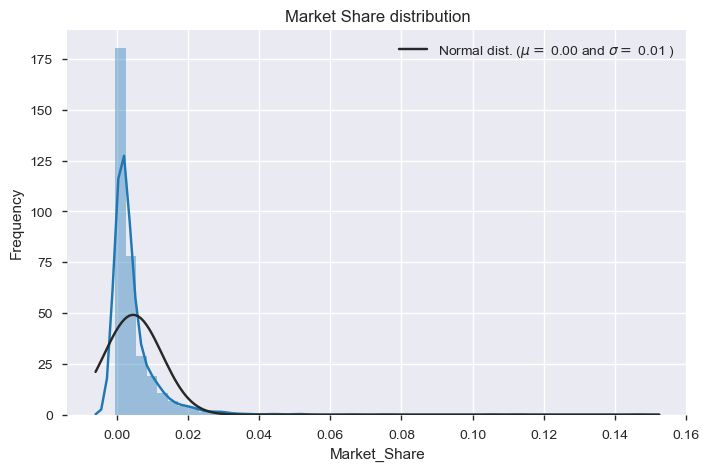

In [11]:
plt.figure(figsize=(8,5))
sns.distplot(data['Market_Share'], fit=norm)
(mu, sigma) = norm.fit(data['Market_Share'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Market Share distribution')

Because the scale is too small, let's multiply it by a big value before applying the log transformation.

Text(0.5,1,'Market Share distribution')

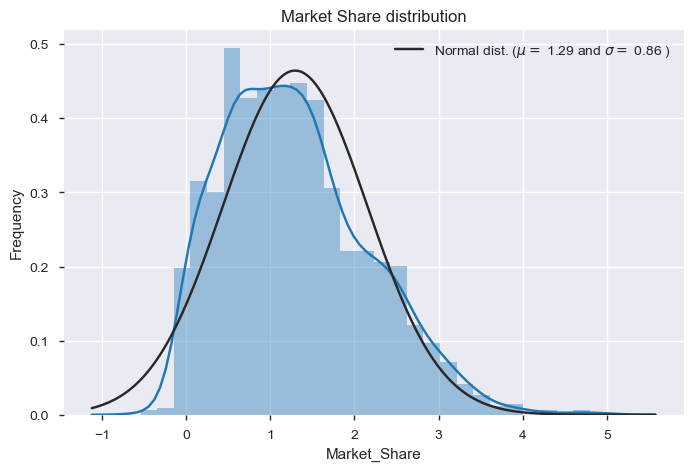

In [12]:
data['raw_Market_Share'] = data['Market_Share']
data['Market_Share'] = np.log1p(data['Market_Share']*1000)

plt.figure(figsize=(8,5))
sns.distplot(data['Market_Share'], fit=norm)
(mu, sigma) = norm.fit(data['Market_Share'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Market Share distribution')

It looks better now and should help the regression models.

What about outliers?
<br>There are some outliers but based on current data understanding they should't be removed because we want to learn from them.

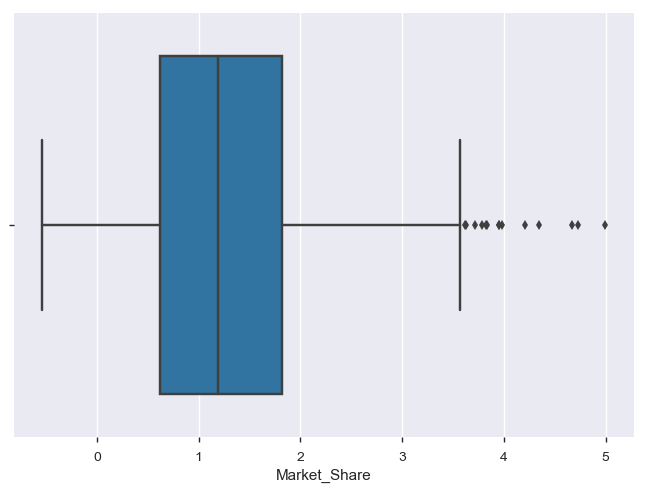

In [13]:
sns.boxplot(x=data['Market_Share'])

#### Create a binary version of the target variable
This will allow to also test a classification approach to help get additional insights. Will use the 0.7% threshold to define this new variable.

In [14]:
succesful_threshold = 0.007
#succesful_threshold = 0.005

data['is_successful'] = np.where(data['raw_Market_Share'] >= succesful_threshold, 1, 0)

In [15]:
data[['raw_Market_Share','is_successful']].sort_values('raw_Market_Share', ascending=True).head(3)

,raw_Market_Share,is_successful
1667,-0.000419,0
1649,-0.000294,0
1630,-0.000212,0


In [16]:
data[['raw_Market_Share','is_successful']].sort_values('raw_Market_Share', ascending=False).head(3)

,raw_Market_Share,is_successful
1572,0.146897,1
576,0.112427,1
1570,0.105396,1


In [17]:
data.groupby('is_successful').size()

is_successful
0    1387
1     329
dtype: int64

We can observe the dataset is imbalanced because the minority (around 20%) of samples are positive. Will test the need of apply some balancing technique later.

#### 1.1.4 Insights
Some pertinent questions to the new response variable.

*What are the most succesful brand families?*
<br>There is a long tail of smaller brands, so let's zoom in the top 10. Looks like 45 is both biggest and most succesful, followed by 41 which is less than a half. 17 is still big and not too successful, followed by many unsuccessful.

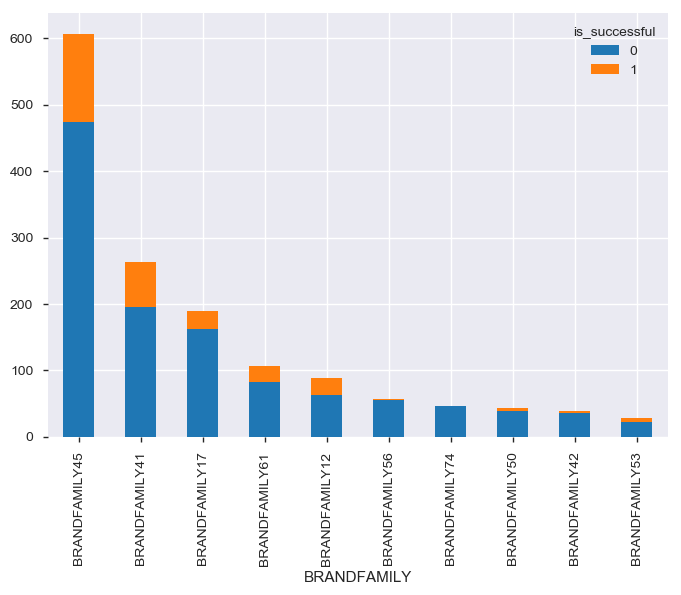

In [18]:
data.groupby(['BRANDFAMILY','is_successful'])['BRANDFAMILY'].count().unstack('is_successful').sort_values(by=(0), ascending=False).head(10).plot.bar(stacked=True)

Is there a yearly trend? Not exactly. First 3 years were not as good as 4 onwards, with grows and shrinks in how successful they are year after year. The only trend might be that after year 4 the company started to have less and less amount of unsuccessful (blue) attempts, although the successful (orange) varies.

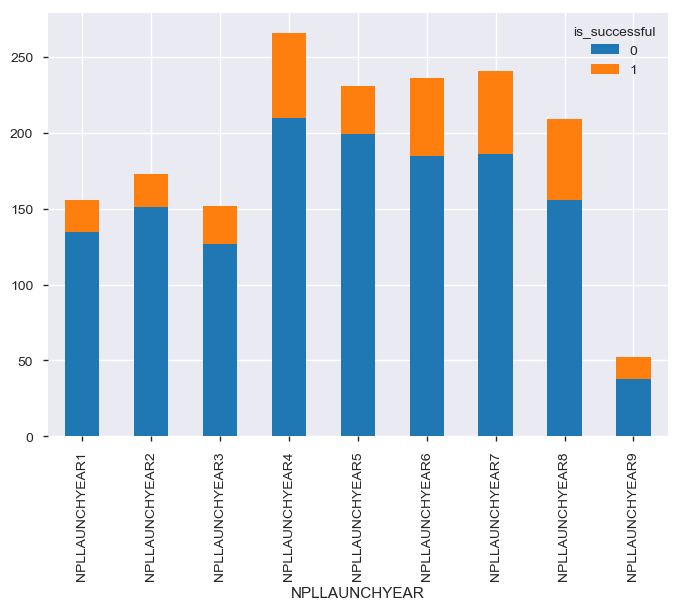

In [19]:
data.groupby(['NPLLAUNCHYEAR','is_successful'])['NPLLAUNCHYEAR'].count().unstack('is_successful').plot.bar(stacked=True)

Does the prediction dataset also has contains rows for different launch years? <br> Yes, then they are not actually new products for the future but a separate blind test. This means the time factor should be kept as an input to the model.

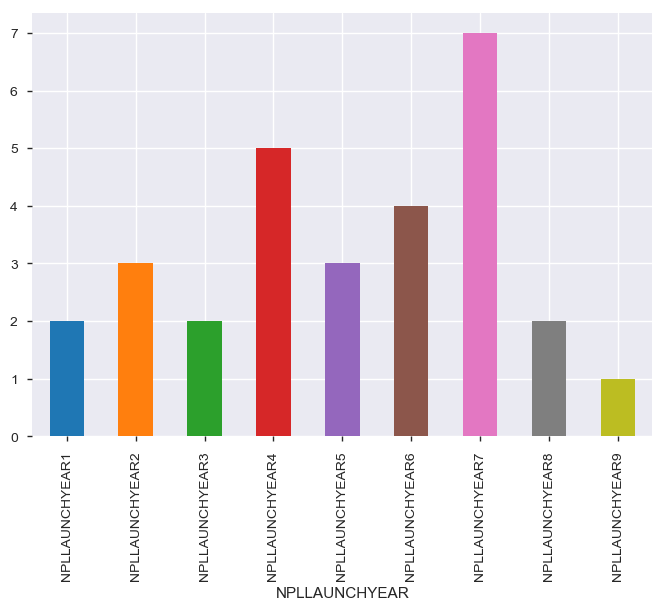

In [20]:
predict.groupby('NPLLAUNCHYEAR').size().plot.bar()

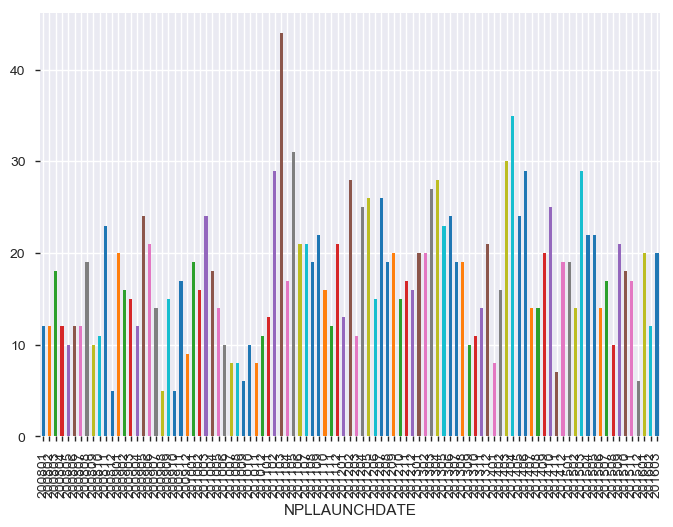

In [21]:
data.groupby('NPLLAUNCHDATE').size().plot.bar()

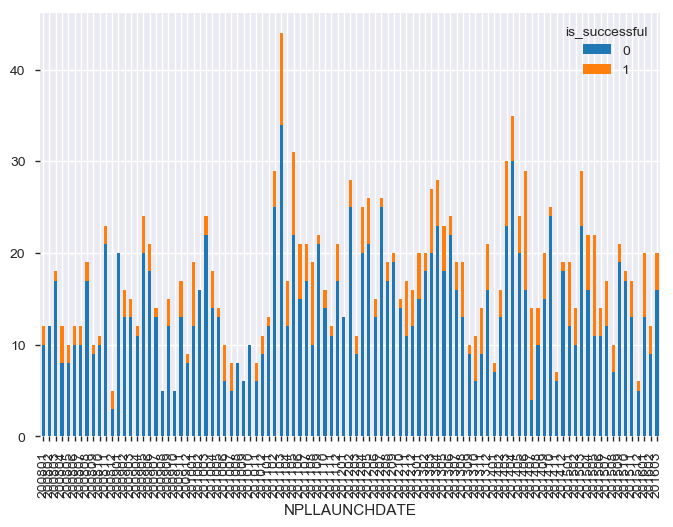

In [22]:
data.groupby(['NPLLAUNCHDATE','is_successful'])['NPLLAUNCHDATE'].count().unstack('is_successful').plot.bar(stacked=True)

Any insights on what markets behave best?

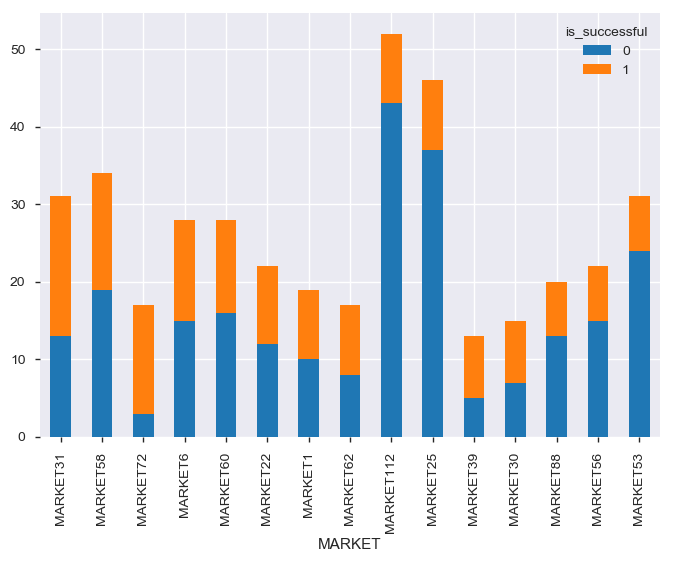

In [23]:
data.groupby(['MARKET','is_successful'])['MARKET'].count().unstack('is_successful').sort_values(by=(1), ascending=False).head(15).plot.bar(stacked=True)

In [24]:
## 1.2 Data Preprocessing

### 1.2.1 Data type conversions

In [25]:
# ITEMSCODE need to be converted to categorical because it is a code
data['ITEMSCODE'] = data['ITEMSCODE'].astype(str)
predict['ITEMSCODE'] = predict['ITEMSCODE'].astype(str)

# NPLLAUNCHDATE need to be converted to date
data['NPLLAUNCHDATE'] = pd.to_datetime(data['NPLLAUNCHDATE'], format='%Y%m')
predict['NPLLAUNCHDATE'] = pd.to_datetime(predict['NPLLAUNCHDATE'], format='%Y%m')

#### Derived features

In [26]:
# Create year/quarter/month
data['launch_year'] = pd.to_datetime(data['NPLLAUNCHDATE']).dt.year
data['launch_quarter'] = pd.to_datetime(data['NPLLAUNCHDATE']).dt.quarter
data['launch_month'] = pd.to_datetime(data['NPLLAUNCHDATE']).dt.month

predict['launch_year'] = pd.to_datetime(predict['NPLLAUNCHDATE']).dt.year
predict['launch_quarter'] = pd.to_datetime(predict['NPLLAUNCHDATE']).dt.quarter
predict['launch_month'] = pd.to_datetime(predict['NPLLAUNCHDATE']).dt.month

# Display
data[['NPLLAUNCHDATE','launch_year','launch_month','launch_quarter']].head()

,NPLLAUNCHDATE,launch_year,launch_month,launch_quarter
0,2011-10-01,2011,10,4
1,2011-10-01,2011,10,4
2,2014-09-01,2014,9,3
3,2014-09-01,2014,9,3
4,2011-10-01,2011,10,4


### 1.2.2 Group variables by data type and set the list of removals

In [27]:
cols = data.columns

hard_removals = ['BRMID' # Looks like an ID
                 ,'NPLLAUNCHDATE' # This one can be removed because two derived features are based on it
                 ,'NPLLAUNCHYEAR' # The derived feature is more useful than this
                 ,'BLDIMAGE' # as plotted above, it's almost entirely image2
                 ,'LEN' # LENCATEGORY is the binarized version, we don't need both
                 ,'raw_Market_Share' # Will use the log-transformed version of it
                ]

class_target = ['is_successful']
regression_target = ['Market_Share']

features = [col for col in cols \
                if col not in hard_removals \
                and col not in class_target \
                and col not in regression_target]

In [28]:
categorical = [var for var in data.columns if (data[var].dtype=='O') and (var in(features))]
numerical =   [var for var in data.columns if (data[var].dtype!='O') and (var in(features))]

In [29]:
print(len(categorical))
print(categorical)

30
['REGION', 'MARKET', 'BRM', 'BRANDDIFFERENTIATOR', 'BRANDFAMILY', 'BRANDONMARKET', 'BRANDSUBFAMILY', 'BRANDSUBFAMILYGROUP', 'BRANDSUBFAMILYGROUPING', 'BRANDSUBFAMILYLINE', 'CHARINDICATOR', 'INDICATOR', 'RTYPE', 'INTERNATIONALINDICATOR', 'ISREPLACEMENT', 'ISSTRATEGIC', 'ITEMSHAPE', 'ITEMSCODE', 'LENCATEGORY', 'PRICECLASS', 'LOCALCLASS', 'MARKETEDBRAND', 'MINDICATOR', 'PCKT', 'PRICECLASSON', 'TCLASS', 'SPECIALFLAVOR', 'THICATEGORY', 'TIPCOLOR', 'TRACKINGSTATUS']


In [30]:
print(len(numerical))
print(numerical)

7
['LATESTPERIODINDEX', 'NCON', 'RETAILPACKPRICE', 'TRCONTE', 'launch_year', 'launch_quarter', 'launch_month']


### 1.2.3 Check cardinality 
Identify high cardinality variables (which have a lot of distinct values).

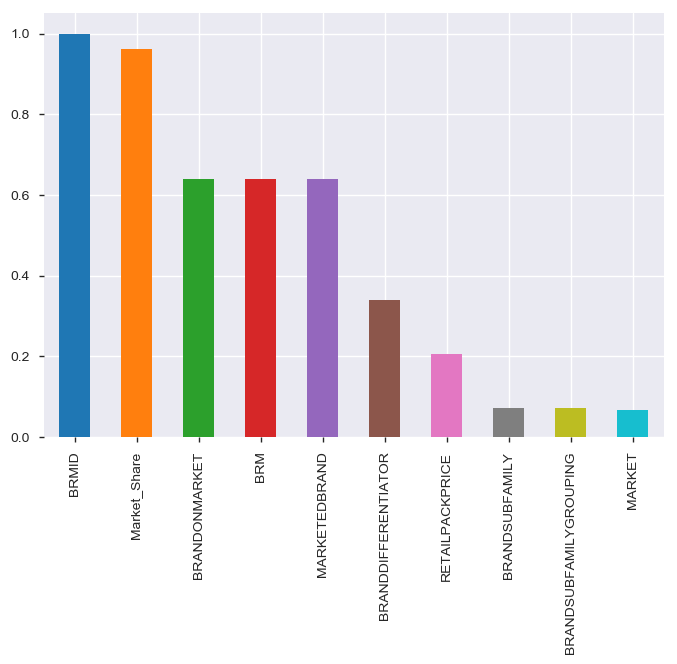

In [31]:
features_granularity = data_profile.description_set['variables'][['count','distinct_count']]
features_granularity['distinct_ratio'] = features_granularity['distinct_count'] / features_granularity['count']
features_granularity['distinct_ratio'].sort_values(ascending=False).head(10).plot.bar()

In [32]:
high_cardinality_variables = get_high_cardinality_variables(data_profile, 0.5)
print('There are %i variables that have high cartinality (over 0.5 distinct ratio):'%len(high_cardinality_variables))
print(high_cardinality_variables)

#low_cardinality_variables = get_low_cardinality_variables(data_profile, ratio=0.002)
#print('\nThere are %i variables that have low cartinality (below 0.003 distinct ratio):'%len(low_cardinality_variables))
#print(low_cardinality_variables)

There are 5 variables that have high cartinality (over 0.5 distinct ratio):
['BRANDONMARKET', 'BRM', 'BRMID', 'MARKETEDBRAND', 'Market_Share']


In [33]:
# We need to keep market share, so let's remove it from the list
high_cardinality_variables.remove('Market_Share')

**Detect constant variables**

In [34]:
constant_variables = get_constant_variables(data_profile)
print('There are %i variables that have constant value'%len(constant_variables))
print( constant_variables)

There are 2 variables that have constant value
['ISREPLACEMENT', 'LATESTPERIODINDEX']


### 1.2.4 Variable populations

In [35]:
missing_perc_threshold = 10 # will consider all variables with at least X% missing values

In [36]:
percent_missing = data.isnull().sum() * 100 / len(data)
print(percent_missing.sort_values(ascending=False).head(7))

bad_pop_variables = list(percent_missing[percent_missing>missing_perc_threshold].index)
print('Variables that crossed the missing % threshold: ', bad_pop_variables)

RTYPE                 72.435897
SPECIALFLAVOR         60.722611
ITEMSHAPE             53.146853
TIPCOLOR              49.009324
launch_month           0.000000
BRANDSUBFAMILYLINE     0.000000
ISSTRATEGIC            0.000000
dtype: float64
Variables that crossed the missing % threshold:  ['RTYPE', 'ITEMSHAPE', 'SPECIALFLAVOR', 'TIPCOLOR']


### 1.2.5 Detect correlated features

Let's use the pandas profiler to remove correlated features.

In [37]:
corr_threshold = 0.8 # will consider variables with at least this value

rejected_variables = data_profile.get_rejected_variables(threshold=corr_threshold)
print('There are %i rejected variables'%len(rejected_variables) + ' that has high correlation with others (current threshold is %f)'%corr_threshold)
print(rejected_variables)

There are 0 rejected variables that has high correlation with others (current threshold is 0.800000)
[]


### 1.2.6 Summarize variable removals and drop

All the variable lists generated above are compiled here.

In [38]:
cols_to_remove = rejected_variables + constant_variables + bad_pop_variables + hard_removals + high_cardinality_variables

print('There are %i rejected variables'%len(cols_to_remove) + ' that can be removed from the dataset later.'%cols_to_remove)
print(cols_to_remove)

There are 16 rejected variables that can be removed from the dataset later.
['ISREPLACEMENT', 'LATESTPERIODINDEX', 'RTYPE', 'ITEMSHAPE', 'SPECIALFLAVOR', 'TIPCOLOR', 'BRMID', 'NPLLAUNCHDATE', 'NPLLAUNCHYEAR', 'BLDIMAGE', 'LEN', 'raw_Market_Share', 'BRANDONMARKET', 'BRM', 'BRMID', 'MARKETEDBRAND']


In [39]:
print(data.shape)
data.drop(cols_to_remove, axis=1, inplace=True)
print(data.shape)

(1716, 45)
(1716, 30)


### 1.2.7 Train/test sampling

Because of the imbalanced nature of the dataset, stratification will be done to assure both train and test datasets are equal in terms of ratio. <br> Most importantly, we should keep the is_successful ratio equal among train and test sets.

In [40]:
# Train test split at 20% stratifying by is_successful
X_train, X_test, y_train_class, y_test_class = train_test_split( data.loc[:, data.columns != 'is_successful']
                                                    , data.is_successful
                                                    , test_size=0.2
                                                    , random_state=42
                                                    , stratify = data.is_successful
                                                   )

In [41]:
# Create separate labels for regression
y_train_reg = X_train['Market_Share']
y_test_reg = X_test['Market_Share']
X_train.drop('Market_Share', axis=1, inplace=True)
X_test.drop('Market_Share', axis=1, inplace=True)

In [42]:
# Datasets shapes
print(X_train.shape)
print(y_train_class.shape)
print(sum(y_train_class))
print(X_test.shape)
print(y_test_class.shape)
print(sum(y_test_class))

(1372, 28)
(1372,)
263
(344, 28)
(344,)
66


In [43]:
print('The ratio of successful records in the original file is: %f'%(sum(data.is_successful) / data.shape[0]*100.0))
print('The ratio of successful records in the training dataset is: %f'%(sum(y_train_class) / len(y_train_class)*100.0))
print('The ratio of successful records in the test dataset is: %f'%(sum(y_test_class) / len(y_test_class)*100.0))

The ratio of successful records in the original file is: 19.172494
The ratio of successful records in the training dataset is: 19.169096
The ratio of successful records in the test dataset is: 19.186047


In [44]:
# In prediction dataset, have only the same variables as in train dataset
X_pred = predict[[var for var in X_train.columns]]

### 1.2.8 Undersampling the majority class
For the classification models, random undersampling will be applied. It is not needed for regression. Create separate datasets for it.

In [45]:
print(X_train.shape)
print(sum(y_train_class))
print(len(y_train_class))
rus = RandomUnderSampler(return_indices=False)
X_train_under, y_train_class_under = rus.fit_sample(X_train, y_train_class)
print(X_train_under.shape)
print(sum(y_train_class_under))
print(len(y_train_class_under))

# Convert numpy array to pandas
X_train_under = pd.DataFrame(X_train_under, columns=X_train.columns)

(1372, 28)
263
1372
(526, 28)
263
526


### 1.2.9 One hot encoding

For some models (like XGBoost) we need to have only numerical inputs, so the categorical features are going be transformed using one hot encoding.
We have to treat high cardinality before that by grouping together the values with lowest frequency.
After the one hot encoded features are added to the dataset, we need to check for correlation again and remove.

In [46]:
# This is the threshold of top frequent values for a categorical feature that will be kept as-is
# Remaining (with lower frequency) will be grouped together under 'Less common values' before one hot encoding. It will result in a smaller number of encoded columns
min_distinct_values = 20 

# List feature names that need to be converted
cat_to_one_hot = [var for var in X_train.columns if (X_train[var].dtype=='O')]
numerical = [var for var in X_train.columns if (X_train[var].dtype!='O')]

# Need to append train and test together before applying one hot encoding
X_train['dataset'] = 'Train'
X_train_under['dataset'] = 'Train'
X_test['dataset'] = 'Test'
X_pred['dataset'] = 'Pred'

all_data = pd.concat([X_train,X_test,X_pred])
all_data_under = pd.concat([X_train_under,X_test,X_pred])

In [47]:
# Will keep the top values as is and put all the lower frequency values grouped as 'other less common values' as defined in a helper function parse_name
for col in all_data[cat_to_one_hot].columns:
    if all_data[col].dtype=='O' and all_data[col].nunique() > min_distinct_values:
        top20 = list(all_data[col].value_counts()[0:min_distinct_values].index)
        all_data[col] = all_data[col].map(parse_name)
    if all_data_under[col].dtype=='O' and all_data_under[col].nunique() > min_distinct_values:
        top20 = list(all_data_under[col].value_counts()[0:min_distinct_values].index)
        all_data_under[col] = all_data_under[col].map(parse_name)

In [48]:
# Apply one hot encoding and save to a separate dataframe
encoded_features = pd.get_dummies(all_data[cat_to_one_hot])
encoded_features_under = pd.get_dummies(all_data_under[cat_to_one_hot])

# Concatenate numerical features along with encoded
all_data_encoded = pd.concat([all_data[numerical], all_data['dataset'],encoded_features], axis=1)
all_data_encoded_under = pd.concat([all_data_under[numerical], all_data_under['dataset'],encoded_features_under], axis=1)

# Split datasets into train and test again and drop helper column, saving in a new separate dataframe
X_train_one_hot = all_data_encoded[all_data_encoded.dataset == 'Train'].drop(['dataset'],axis=1)
X_test_one_hot = all_data_encoded[all_data_encoded.dataset == 'Test'].drop(['dataset'],axis=1)
X_pred_one_hot = all_data_encoded[all_data_encoded.dataset == 'Pred'].drop(['dataset'],axis=1)

X_train_one_hot_under = all_data_encoded_under[all_data_encoded_under.dataset == 'Train'].drop(['dataset'],axis=1)
X_test_one_hot_under = all_data_encoded_under[all_data_encoded_under.dataset == 'Test'].drop(['dataset'],axis=1)
X_pred_one_hot_under = all_data_encoded_under[all_data_encoded_under.dataset == 'Pred'].drop(['dataset'],axis=1)

# Remove dataset column from original X datasets
remove = ['dataset']
X_train.drop(remove,axis=1,inplace=True)
X_train_under.drop(remove,axis=1,inplace=True)
X_test.drop(remove,axis=1,inplace=True)
X_pred.drop(remove,axis=1,inplace=True)

In [49]:
print('Total amount of one hot encoded features added: ' ,encoded_features.shape[1])
print('New train dataset shape is: ',X_train_one_hot.shape)
print('New test dataset shape is: ',X_test_one_hot.shape)
print('New pred dataset shape is: ',X_pred_one_hot.shape)

Total amount of one hot encoded features added:  259
New train dataset shape is:  (1372, 265)
New test dataset shape is:  (344, 265)
New pred dataset shape is:  (29, 265)


In [50]:
encoded_features.head()

,REGION_REGION1,REGION_REGION2,REGION_REGION3,REGION_REGION4,MARKET_MARKET108,MARKET_MARKET112,MARKET_MARKET15,MARKET_MARKET23,MARKET_MARKET25,MARKET_MARKET31,...,TCLASS_TCLASS2,TCLASS_TCLASS3,TCLASS_TCLASS4,THICATEGORY_THICATEGORY1,THICATEGORY_THICATEGORY2,THICATEGORY_THICATEGORY3,THICATEGORY_THICATEGORY4,THICATEGORY_THICATEGORY5,TRACKINGSTATUS_TRACKINGSTATUS1,TRACKINGSTATUS_TRACKINGSTATUS2
989,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,1
1628,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1148,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
162,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1127,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1


Remove correlated features after One Hot Encoding

In [51]:
corr_threshold = 0.8

# Use Pandas profiling again to check for correlation between the new encoded features
train_data_profile = pandas_profiling.ProfileReport(X_train_one_hot)
train_data_profile_under = pandas_profiling.ProfileReport(X_train_one_hot_under)

# List the features with correlation value above the threshold
rejected_variables = train_data_profile.get_rejected_variables(threshold=corr_threshold)
print('There are %i rejected variables'%len(rejected_variables) + ' that has high correlation with others (current threshold is %f)'%corr_threshold)
print(rejected_variables)

rejected_variables_under = train_data_profile_under.get_rejected_variables(threshold=corr_threshold)
print('\nIn the undersampled dataset, there are %i rejected variables'%len(rejected_variables_under) + ' that has high correlation with others (current threshold is %f)'%corr_threshold)
print(rejected_variables_under)

# Remove these features from encoded datasets
X_train_one_hot.drop(rejected_variables, axis=1, inplace=True)
X_test_one_hot.drop(rejected_variables, axis=1, inplace=True)
X_pred_one_hot.drop(rejected_variables, axis=1, inplace=True)

X_train_one_hot_under.drop(rejected_variables_under, axis=1, inplace=True)
X_test_one_hot_under.drop(rejected_variables_under, axis=1, inplace=True)
X_pred_one_hot_under.drop(rejected_variables_under, axis=1, inplace=True)

There are 71 rejected variables that has high correlation with others (current threshold is 0.800000)
['BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING109', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING112', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING115', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING12', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING120', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING133', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING17', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING41', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING42', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING45', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING47', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING55', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING63', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING66', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING78', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING85', 'BRANDSUBFAMILYGROUPING_BRANDSUBFAMILYGROUPING86', 'BRANDSUBFAMILYGROUPING_B

**Preparing Data Pools (required for CatBoost)**

In [52]:
# List categorical features indexes
train_features = [var for var in X_train.columns if (X_train[var].dtype=='O')]
train_features_idx = [X_train.columns.get_loc(var) for var in train_features]

train_features_under = [var for var in X_train_under.columns if (X_train_under[var].dtype=='O')]
train_features_under_idx = [X_train_under.columns.get_loc(var) for var in train_features_under]

pred_features_idx = [X_pred.columns.get_loc(var) for var in train_features]

# Regression pool
train_pool_reg = Pool(X_train
                      ,y_train_reg
                      ,cat_features=train_features_idx)

test_pool_reg = Pool(X_test
                      ,y_test_reg
                      ,cat_features=train_features_idx)

# Classification pool (undersampling, without one hot encoding)
train_pool_class = Pool(X_train_under
                      ,y_train_class_under
                      ,cat_features=train_features_idx)

test_pool_class = Pool(X_test
                      ,y_test_class
                      ,cat_features=train_features_idx)

# Prediction set pool
pred_pool_reg = Pool(X_pred
                      ,cat_features=pred_features_idx)


# 2 Modeling

## 2.1 Regression

### 2.1.1 CatBoost Regressor

In [53]:
cat_reg_model = CatBoostRegressor(loss_function = 'MAE', # Options are: MAE, MAPE, Poisson, Quantile, RMSE, LogLinQuantile, Lq
                          logging_level = 'Silent',
                          task_type = 'GPU',
                          random_seed = 42,
                          )

In [54]:
%%time
run_catboost_reg = 1
if run_catboost_reg:
    cat_reg_model.fit(train_pool_reg) # ~40 s

Wall time: 38.2 s


**Feature importance**

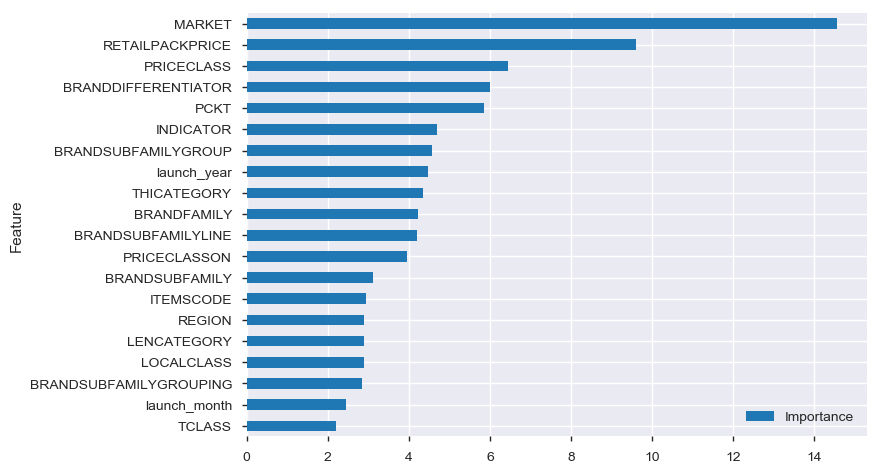

In [55]:
pd.DataFrame(cat_reg_model.get_feature_importance(data=train_pool_class
                                                   , prettified=True
                                                   , thread_count=-1
                                                   , verbose=False)
             , columns = ['Feature','Importance'])\
            .set_index('Feature')\
            .sort_values(by='Importance',ascending=False)\
            .head(20).sort_values(by='Importance',ascending=True)\
            .plot.barh()

**Train performance**

In [56]:
# Predict train data
reg_train_predictions = cat_reg_model.predict(train_pool_reg)

# Apply exponential and divide to get back to the original distribution
reg_train_predictions_exp = np.expm1(reg_train_predictions)/1000
y_train_reg_exp = np.expm1(y_train_reg)/1000

# Keep data separate for later use
cat_reg_train_actual = y_train_reg_exp.copy()
cat_reg_train_pred = reg_train_predictions_exp.copy()

cat_reg_train_summary = pd.DataFrame(
    [['CatBoost Regressor'
    ,'Train'
    ,mean_absolute_error(y_train_reg_exp, reg_train_predictions_exp)
    ,mean_squared_error(y_train_reg_exp, reg_train_predictions_exp)
    ,np.sqrt(mean_squared_error(y_train_reg_exp, reg_train_predictions_exp))
    ,r2_score(y_train_reg_exp, reg_train_predictions_exp)]]
    ,columns=['Model','Dataset','MAE','MSE','RMSE','R2']
    )

cat_reg_train_summary

,Model,Dataset,MAE,MSE,RMSE,R2
0,CatBoost Regressor,Train,0.00262,0.000061,0.007819,0.176777


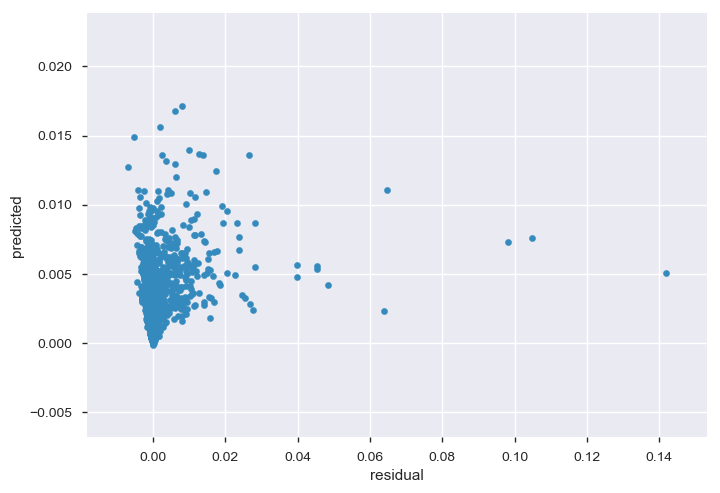

In [57]:
residual = y_train_reg_exp - reg_train_predictions_exp
predicted = reg_train_predictions_exp
df = pd.DataFrame({'residual':residual, 'predicted':predicted})
df.plot('residual', 'predicted', kind='scatter')

(0, 0.025)

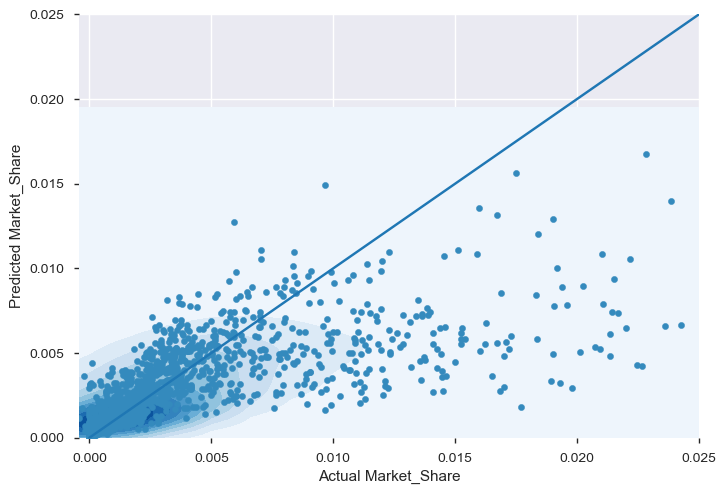

In [58]:
actual = y_train_reg_exp
predicted = reg_train_predictions_exp

size = 0.025
sns.kdeplot(actual, predicted, cmap="Blues", shade=True, shade_lowest=True)
df = pd.DataFrame({'Actual Market_Share':actual, 'Predicted Market_Share':predicted})
df.plot('Actual Market_Share', 'Predicted Market_Share', kind='scatter', ax=plt.gca())
plt.plot([0,np.max(actual)],[0,np.max(actual)])
plt.xlim([np.min(actual),size])
plt.ylim([0,size])

**Test performance**

In [59]:
# Predict test data
reg_test_predictions = cat_reg_model.predict(test_pool_reg)

# Apply exponential and divide to get back to the original distribution
reg_test_predictions_exp = np.expm1(reg_test_predictions)/1000
y_test_reg_exp = np.expm1(y_test_reg)/1000

# Keep data separate for later use
cat_reg_test_actual = y_test_reg_exp.copy()
cat_reg_test_pred = reg_test_predictions_exp.copy()

cat_reg_test_summary = pd.DataFrame(
    [['CatBoost Regressor'
    ,'Test'
    ,mean_absolute_error(y_test_reg_exp, reg_test_predictions_exp)
    ,mean_squared_error(y_test_reg_exp, reg_test_predictions_exp)
    ,np.sqrt(mean_squared_error(y_test_reg_exp, reg_test_predictions_exp))
    ,r2_score(y_test_reg_exp, reg_test_predictions_exp)]]
    ,columns=['Model','Dataset','MAE','MSE','RMSE','R2']
    )

cat_reg_test_summary

,Model,Dataset,MAE,MSE,RMSE,R2
0,CatBoost Regressor,Test,0.002633,0.000027,0.005213,0.151676


(0, 0.015)

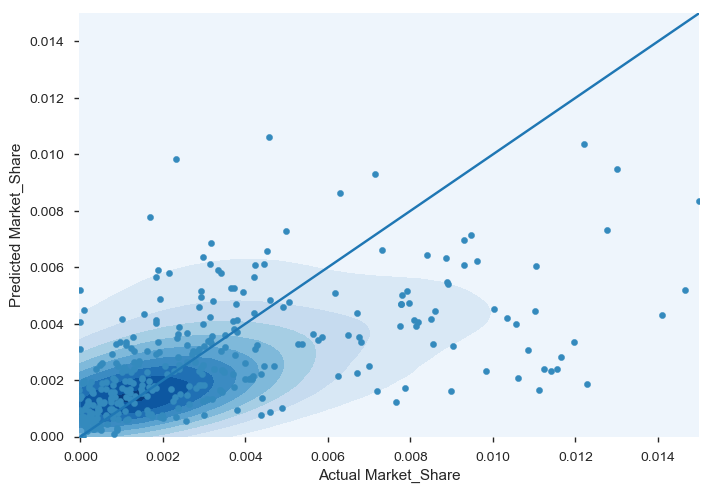

In [60]:
actual = y_test_reg_exp
predicted = reg_test_predictions_exp

size = 0.015
sns.kdeplot(actual, predicted, cmap="Blues", shade=True, shade_lowest=True)
df = pd.DataFrame({'Actual Market_Share':actual, 'Predicted Market_Share':predicted})
df.plot('Actual Market_Share', 'Predicted Market_Share', kind='scatter', ax=plt.gca())
plt.plot([0,np.max(actual)],[0,np.max(actual)])
plt.xlim([np.min(actual),size])
plt.ylim([0,size])

### 2.1.2 XGBoost Regressor

In [61]:
paramGrid = {  'n_estimators': [10,20,50]#,1000]
             , 'max_depth': [3,5]
             , 'min_child_weight': [0,1]
             , 'learning_rate': [0.1,0.01]
             , 'colsample_bytree': [0.85,1]
             , 'subsample': [0.85,1]
             , 'gamma': [0,1,5]
             , 'tree_method': ['gpu_hist']
             , 'predictor': ['gpu_predictor']
             }

#fit_params = {
#                'early_stopping_rounds': 25
#              , 'eval_set':[(X_val, y_val)]
#              , 'eval_metric':'mae'
#              }

kfold = KFold(n_splits=8
             , shuffle=True
             , random_state=7
             )

xgb_model_reg = GridSearchCV(xgboost.XGBRegressor()
                     , param_grid = paramGrid
                     #, fit_params = fit_params
                     , verbose = 0
                     , cv = kfold
                     , n_jobs = -1
                     ) 

In [62]:
%%time
run_xgb_reg = 1
if run_xgb_reg:
    xgb_model_reg.fit(X_train_one_hot, y_train_reg) # ~6 min

Wall time: 7min 29s


**Feature importance**

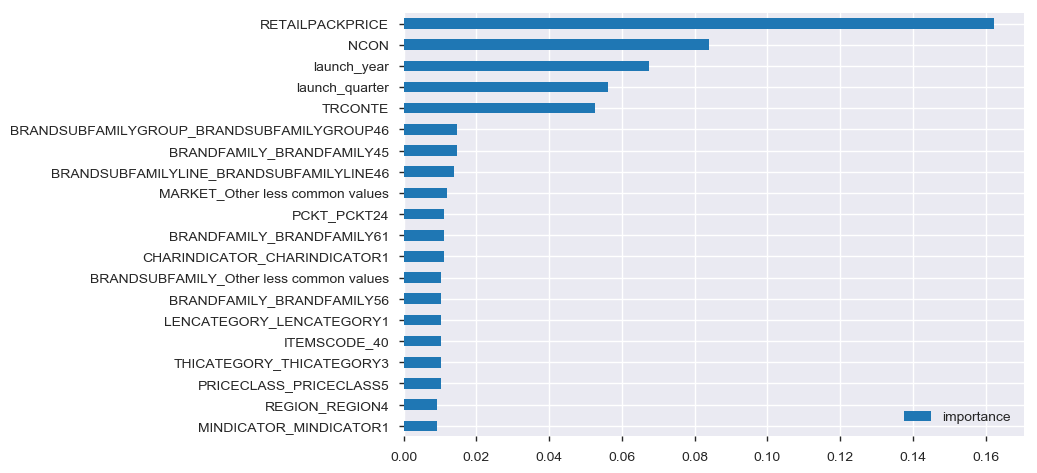

In [63]:
idx = xgb_model_reg.best_estimator_.feature_importances_.argsort()[::-1]
labels = X_train_one_hot.columns[idx]
pd.DataFrame(index=labels,data=xgb_model_reg.best_estimator_.feature_importances_[idx],columns=['importance']).head(20).sort_values(by='importance', ascending=True).plot.barh()

**Train performance**

In [64]:
# Predict train data
reg_train_predictions = xgb_model_reg.predict(X_train_one_hot)

# Apply exponential and divide to get back to the original distribution
reg_train_predictions_exp = np.expm1(reg_train_predictions)/1000
y_train_reg_exp = np.expm1(y_train_reg)/1000

# Keep data separate for later use
xgb_reg_train_actual = y_train_reg_exp.copy()
xgb_reg_train_pred = reg_train_predictions_exp.copy()

xgb_reg_train_summary = pd.DataFrame(
    [['XGBoost Regressor'
    ,'Train'
    ,mean_absolute_error(y_train_reg_exp, reg_train_predictions_exp)
    ,mean_squared_error(y_train_reg_exp, reg_train_predictions_exp)
    ,np.sqrt(mean_squared_error(y_train_reg_exp, reg_train_predictions_exp))
    ,r2_score(y_train_reg_exp, reg_train_predictions_exp)]]
    ,columns=['Model','Dataset','MAE','MSE','RMSE','R2']
    )

xgb_reg_train_summary

,Model,Dataset,MAE,MSE,RMSE,R2
0,XGBoost Regressor,Train,0.002847,0.000056,0.007462,0.250264


(0, 0.025)

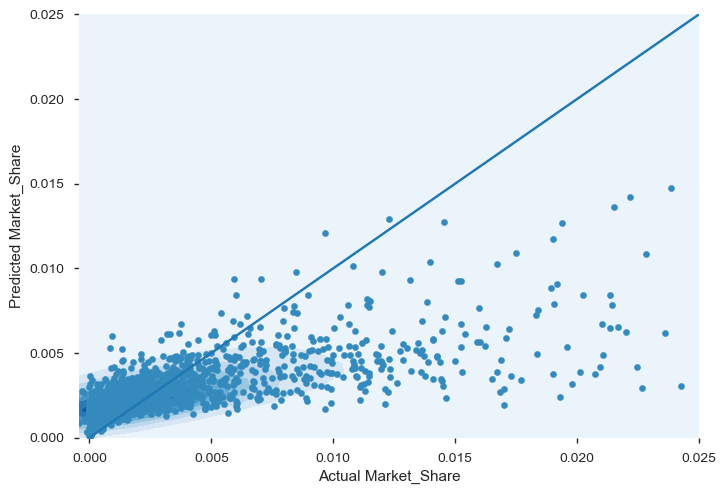

In [65]:
actual = y_train_reg_exp
predicted = reg_train_predictions_exp

size = 0.025
sns.kdeplot(actual, predicted, cmap="Blues", shade=True, shade_lowest=True)
df = pd.DataFrame({'Actual Market_Share':actual, 'Predicted Market_Share':predicted})
df.plot('Actual Market_Share', 'Predicted Market_Share', kind='scatter', ax=plt.gca())
plt.plot([0,np.max(actual)],[0,np.max(actual)])
plt.xlim([np.min(actual),size])
plt.ylim([0,size])

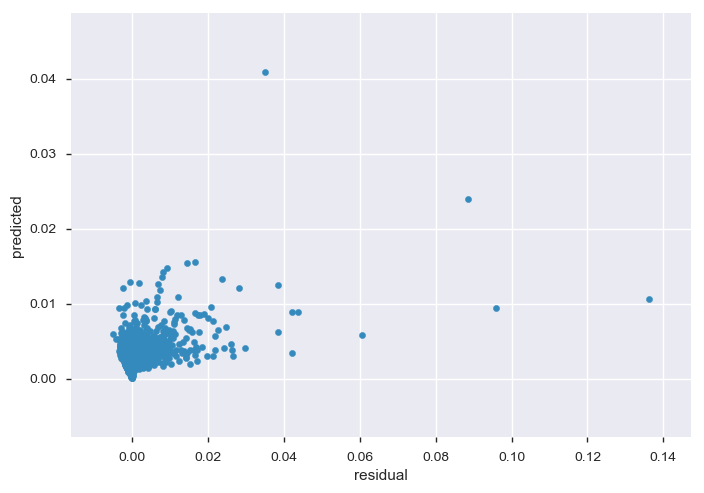

In [66]:
residual = y_train_reg_exp - reg_train_predictions_exp
predicted = reg_train_predictions_exp
df = pd.DataFrame({'residual':residual, 'predicted':predicted})
df.plot('residual', 'predicted', kind='scatter')
#plt.plot([0,np.max(actual)],[0,np.max(predicted)])

**Test performance**

In [67]:
# Predict test data
reg_test_predictions = xgb_model_reg.predict(X_test_one_hot)

# Apply exponential and divide to get back to the original distribution
reg_test_predictions_exp = np.expm1(reg_test_predictions)/1000
y_test_reg_exp = np.expm1(y_test_reg)/1000

# Keep data separate for later use
xgb_reg_test_actual = y_test_reg_exp.copy()
xgb_reg_test_pred = reg_test_predictions_exp.copy()

xgb_reg_test_summary = pd.DataFrame(
    [['XGBoost Regressor'
    ,'Test'
    ,mean_absolute_error(y_test_reg_exp, reg_test_predictions_exp)
    ,mean_squared_error(y_test_reg_exp, reg_test_predictions_exp)
    ,np.sqrt(mean_squared_error(y_test_reg_exp, reg_test_predictions_exp))
    ,r2_score(y_test_reg_exp, reg_test_predictions_exp)]]
    ,columns=['Model','Dataset','MAE','MSE','RMSE','R2']
    )
xgb_reg_test_summary

,Model,Dataset,MAE,MSE,RMSE,R2
0,XGBoost Regressor,Test,0.00291,0.000029,0.005407,0.087254


(0, 0.015)

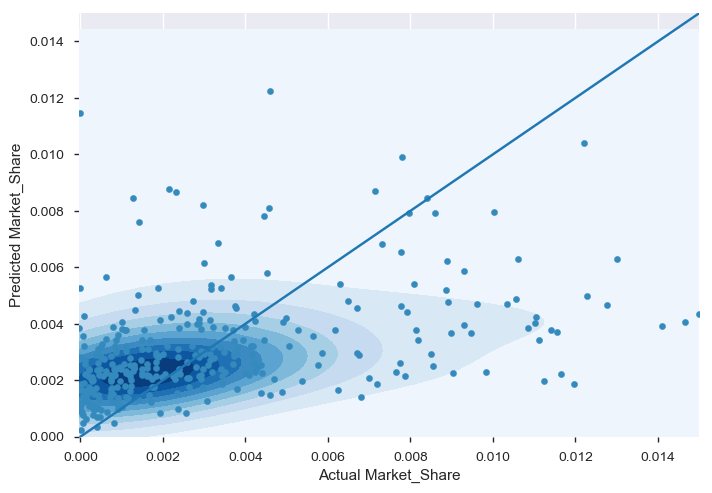

In [68]:
actual = y_test_reg_exp
predicted = reg_test_predictions_exp

size = 0.015
sns.kdeplot(actual, predicted, cmap="Blues", shade=True, shade_lowest=True)
df = pd.DataFrame({'Actual Market_Share':actual, 'Predicted Market_Share':predicted})
df.plot('Actual Market_Share', 'Predicted Market_Share', kind='scatter', ax=plt.gca())
plt.plot([0,np.max(actual)],[0,np.max(actual)])
plt.xlim([np.min(actual),size])
plt.ylim([0,size])

## 2.2 Classification

### 2.3.1 CatBoost Classifier

In [69]:
cat_clas_model = CatBoostClassifier(loss_function='Logloss', 
                           logging_level = 'Silent',
                           task_type = 'GPU',
                           random_seed = 42
                           )

In [70]:
%%time
run_catboost_class = 1
if run_catboost_class:
    cat_clas_model.fit(train_pool_class)

Wall time: 57.8 s


**Feature importance**

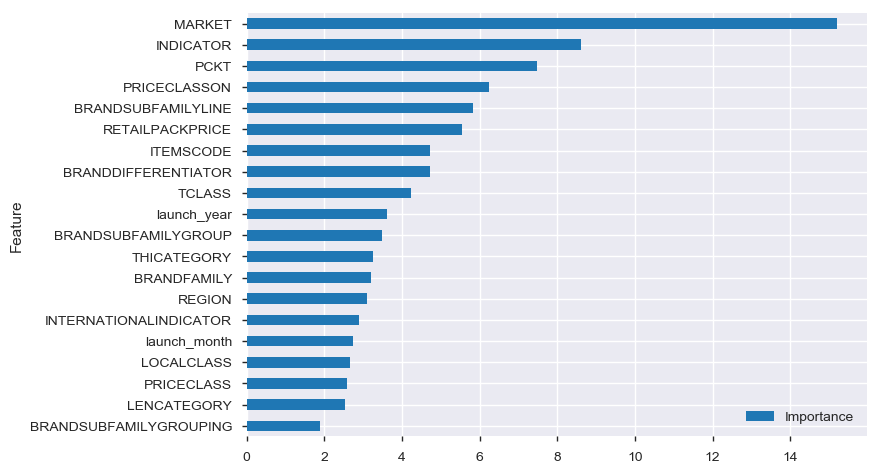

In [71]:
pd.DataFrame(cat_clas_model.get_feature_importance(data=train_pool_class
                                                   , prettified=True
                                                   , thread_count=-1
                                                   , verbose=False)
             , columns = ['Feature','Importance'])\
            .set_index('Feature')\
            .sort_values(by='Importance',ascending=False)\
            .head(20).sort_values(by='Importance',ascending=True)\
            .plot.barh()

**Train performance**

In [72]:
clas_train_predictions = cat_clas_model.predict(train_pool_class)
cat_clas_train_actual = y_train_class_under.copy()
cat_clas_train_pred = clas_train_predictions.copy()

cat_clas_train_summary = pd.DataFrame(
    [['CatBoost Classifier'
    ,'Train'
    ,accuracy_score(y_train_class_under, clas_train_predictions)
    ,precision_score(y_train_class_under, clas_train_predictions)
    ,recall_score(y_train_class_under, clas_train_predictions)
    ,f1_score(y_train_class_under, clas_train_predictions)
    ,roc_auc_score(y_train_class_under, clas_train_predictions)
    ,log_loss(y_train_class_under, clas_train_predictions)]]
    ,columns=['Model','Dataset','Accuracy','Precision','Recall','F1','ROC AUC','Log Loss']
    )

print('\n',classification_report(y_train_class_under, clas_train_predictions))
cat_clas_train_summary


               precision    recall  f1-score   support

           0       0.95      0.90      0.93       263
           1       0.91      0.95      0.93       263

   micro avg       0.93      0.93      0.93       526
   macro avg       0.93      0.93      0.93       526
weighted avg       0.93      0.93      0.93       526



,Model,Dataset,Accuracy,Precision,Recall,F1,ROC AUC,Log Loss
0,CatBoost Classifier,Train,0.927757,0.909091,0.95057,0.929368,0.927757,2.495235


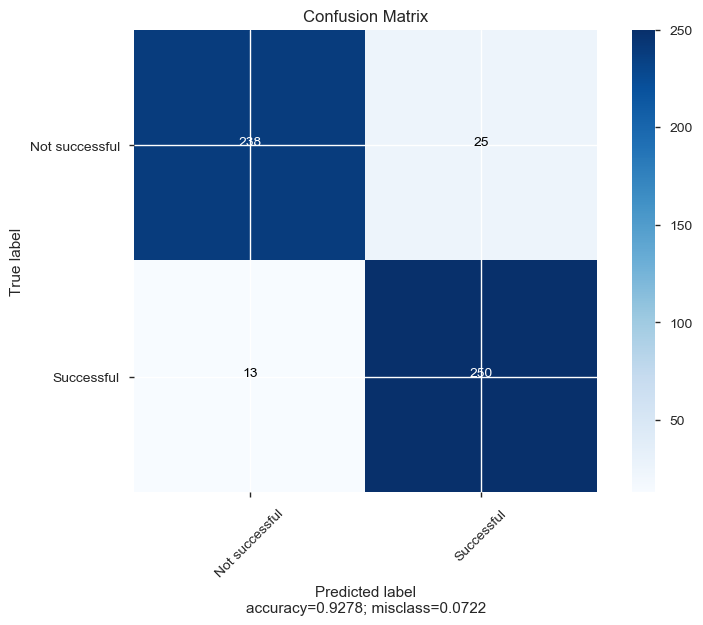

In [73]:
plot_confusion_matrix(cm           = confusion_matrix(y_train_class_under, clas_train_predictions), 
                      normalize    = False,
                      target_names = ['Not successful','Successful'],
                      title        = "Confusion Matrix")

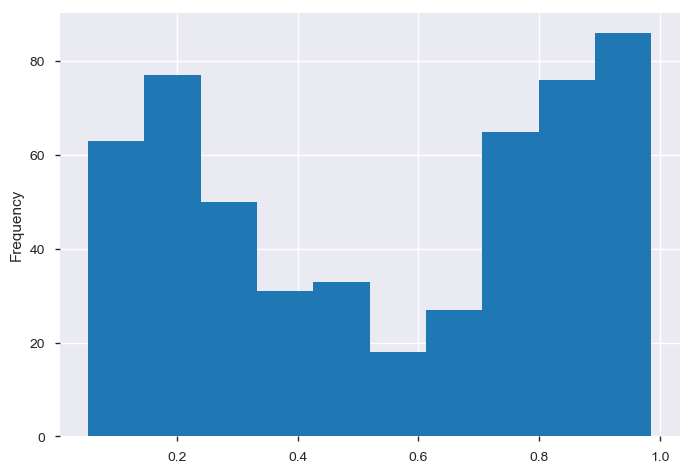

In [74]:
clas_train_predictions_prob = cat_clas_model.predict_proba(train_pool_class)
pd.DataFrame(clas_train_predictions_prob)[1].plot.hist()

**Test performance**

In [75]:
clas_test_predictions = cat_clas_model.predict(test_pool_class)

cat_clas_test_actual = y_test_class.copy()
cat_clas_test_pred = clas_test_predictions.copy()

cat_clas_test_summary = pd.DataFrame(
    [['CatBoost Classifier'
    ,'Test'
    ,accuracy_score(y_test_class, clas_test_predictions)
    ,precision_score(y_test_class, clas_test_predictions)
    ,recall_score(y_test_class, clas_test_predictions)
    ,f1_score(y_test_class, clas_test_predictions)
    ,roc_auc_score(y_test_class, clas_test_predictions)
    ,log_loss(y_test_class, clas_test_predictions)]]
    ,columns=['Model','Dataset','Accuracy','Precision','Recall','F1','ROC AUC','Log Loss']
    )

cat_clas_test_summary

,Model,Dataset,Accuracy,Precision,Recall,F1,ROC AUC,Log Loss
0,CatBoost Classifier,Test,0.718023,0.365217,0.636364,0.464088,0.686887,9.739301


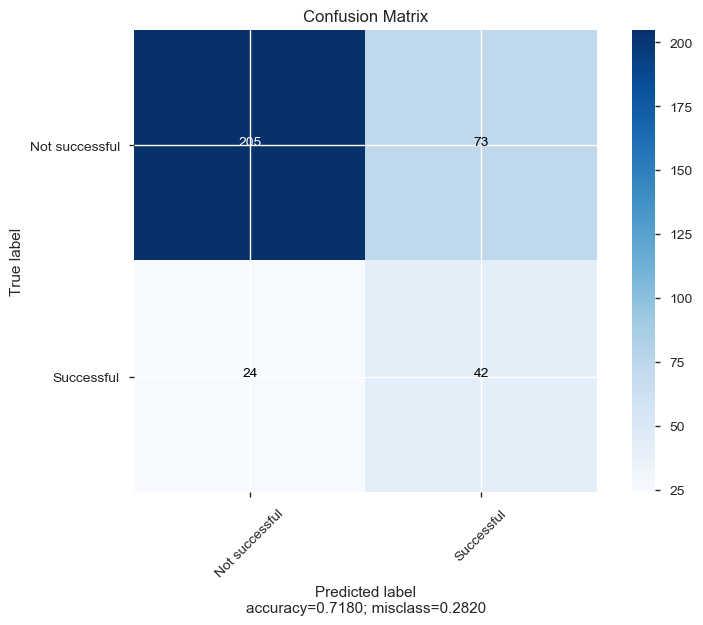

In [76]:
plot_confusion_matrix(cm           = confusion_matrix(y_test_class, clas_test_predictions), 
                      normalize    = False,
                      target_names = ['Not successful','Successful'],
                      title        = "Confusion Matrix")

### 2.2.2 XGBoost Classifier

In [77]:
paramGrid = {  'n_estimators': [10, 20, 50]
             , 'max_depth': [3,6]
             , 'min_child_weight': [0, 1]
             , 'learning_rate': [0.1, 0.01]
             , 'colsample_bytree': [0.85, 1]
             , 'subsample': [0.85, 1]
             , 'gamma': [0, 1, 5]
             , 'tree_method': ['gpu_hist']
             , 'predictor': ['gpu_predictor']
             }

#fit_params = {
#                'early_stopping_rounds': 10
#              , 'eval_set':[(X_test, y_test_class)]
#              , 'eval_metric':['auc','error']
#              }

kfold = StratifiedKFold(n_splits=8
                        , shuffle=True
                        , random_state=7)

xgb_model_clas = GridSearchCV(xgboost.XGBClassifier()
                     , param_grid = paramGrid
                     # , fit_params = fit_params
                     , verbose = 0
                     , scoring = 'roc_auc'
                     , cv = kfold
                     , n_jobs = -1
                     ) 

In [78]:
# For some reason these became objects again, converting back to numeric
fix_to_numeric = ['NCON','RETAILPACKPRICE','TRCONTE','launch_year','launch_quarter','launch_month' ]
for col in fix_to_numeric:
    X_train_one_hot_under[col] = pd.to_numeric(X_train_one_hot_under[col])
    X_test_one_hot_under[col] = pd.to_numeric(X_train_one_hot_under[col])

In [79]:
%%time
run_xgb_class = 1
if run_xgb_class:
    xgb_model_clas.fit(X_train_one_hot_under, y_train_class_under)

Wall time: 8min 29s


**Feature importance**

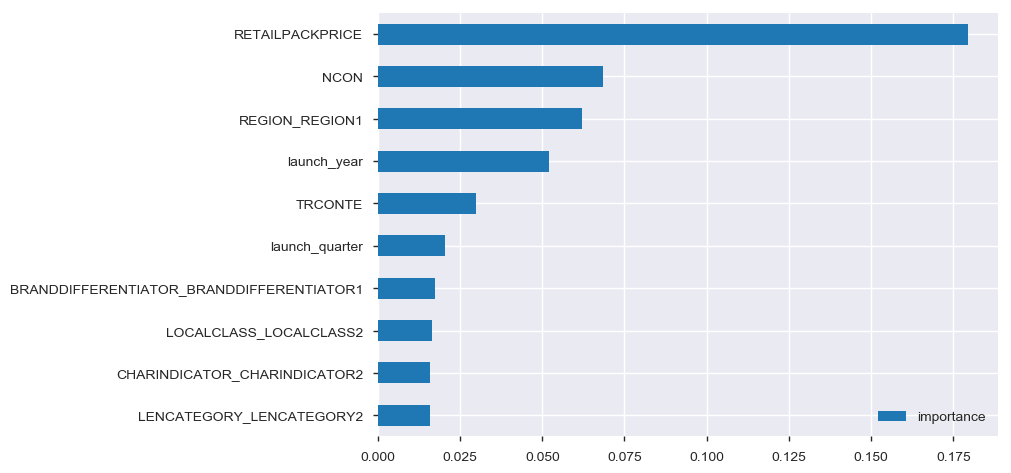

In [80]:
idx = xgb_model_clas.best_estimator_.feature_importances_.argsort()[::-1]
labels = X_train_one_hot.columns[idx]
pd.DataFrame(index=labels,data=xgb_model_clas.best_estimator_.feature_importances_[idx],columns=['importance']).head(10).sort_values(by='importance', ascending=True).plot.barh()

**Train performance**

In [81]:
clas_train_predictions = xgb_model_clas.predict(X_train_one_hot_under)
xgb_clas_train_actual = y_train_class_under.copy()
xgb_clas_train_pred = clas_train_predictions.copy()

xgb_clas_train_summary = pd.DataFrame(
    [['XGBoost Classifier'
    ,'Train'
    ,accuracy_score(y_train_class_under, clas_train_predictions)
    ,precision_score(y_train_class_under, clas_train_predictions)
    ,recall_score(y_train_class_under, clas_train_predictions)
    ,f1_score(y_train_class_under, clas_train_predictions)
    ,roc_auc_score(y_train_class_under, clas_train_predictions)
    ,log_loss(y_train_class_under, clas_train_predictions)]]
    ,columns=['Model','Dataset','Accuracy','Precision','Recall','F1','ROC AUC','Log Loss']
    )

print('\n',classification_report(y_train_class_under, clas_train_predictions))
cat_clas_train_summary


               precision    recall  f1-score   support

           0       0.97      0.98      0.98       263
           1       0.98      0.97      0.98       263

   micro avg       0.98      0.98      0.98       526
   macro avg       0.98      0.98      0.98       526
weighted avg       0.98      0.98      0.98       526



,Model,Dataset,Accuracy,Precision,Recall,F1,ROC AUC,Log Loss
0,CatBoost Classifier,Train,0.927757,0.909091,0.95057,0.929368,0.927757,2.495235


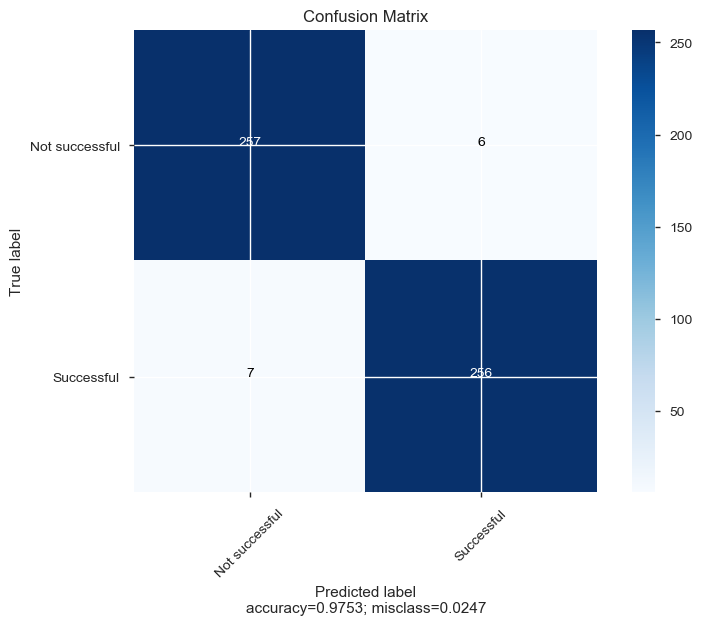

In [82]:
plot_confusion_matrix(cm           = confusion_matrix(y_train_class_under, clas_train_predictions), 
                      normalize    = False,
                      target_names = ['Not successful','Successful'],
                      title        = "Confusion Matrix")

**Test performance**

In [83]:
clas_test_predictions = xgb_model_clas.predict(X_test_one_hot_under)
xgb_clas_test_actual = y_test_class.copy()
xgb_clas_test_pred = clas_test_predictions.copy()

xgb_clas_test_summary = pd.DataFrame(
    [['XGBoost Classifier'
    ,'Test'
    ,accuracy_score(y_test_class, clas_test_predictions)
    ,precision_score(y_test_class, clas_test_predictions)
    ,recall_score(y_test_class, clas_test_predictions)
    ,f1_score(y_test_class, clas_test_predictions)
    ,roc_auc_score(y_test_class, clas_test_predictions)
    ,log_loss(y_test_class, clas_test_predictions)]]
    ,columns=['Model','Dataset','Accuracy','Precision','Recall','F1','ROC AUC','Log Loss']
    )

print('\n',classification_report(y_test_class, clas_test_predictions))
xgb_clas_test_summary


               precision    recall  f1-score   support

           0       0.87      0.63      0.73       278
           1       0.28      0.61      0.38        66

   micro avg       0.63      0.63      0.63       344
   macro avg       0.58      0.62      0.56       344
weighted avg       0.76      0.63      0.67       344



,Model,Dataset,Accuracy,Precision,Recall,F1,ROC AUC,Log Loss
0,XGBoost Classifier,Test,0.627907,0.28169,0.606061,0.384615,0.619577,12.851875


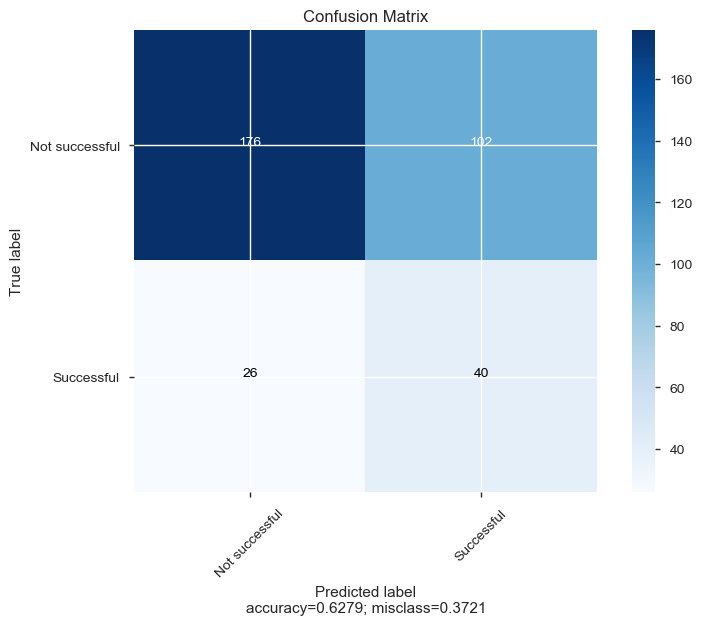

In [84]:
plot_confusion_matrix(cm           = confusion_matrix(y_test_class, clas_test_predictions), 
                      normalize    = False,
                      target_names = ['Not successful','Successful'],
                      title        = "Confusion Matrix")

### 2.3 Model results
Analyse results and find the best regression/classification models to be used for final predictions.

In [85]:
reg_summary = pd.concat([cat_reg_train_summary,cat_reg_test_summary,xgb_reg_train_summary,xgb_reg_test_summary])
clas_summary = pd.concat([cat_clas_train_summary,cat_clas_test_summary,xgb_clas_train_summary,xgb_clas_test_summary])

In [86]:
reg_summary

,Model,Dataset,MAE,MSE,RMSE,R2
0,CatBoost Regressor,Train,0.002620,0.000061,0.007819,0.176777
0,CatBoost Regressor,Test,0.002633,0.000027,0.005213,0.151676
0,XGBoost Regressor,Train,0.002847,0.000056,0.007462,0.250264
0,XGBoost Regressor,Test,0.002910,0.000029,0.005407,0.087254


In [87]:
clas_summary

,Model,Dataset,Accuracy,Precision,Recall,F1,ROC AUC,Log Loss
0,CatBoost Classifier,Train,0.927757,0.909091,0.950570,0.929368,0.927757,2.495235
0,CatBoost Classifier,Test,0.718023,0.365217,0.636364,0.464088,0.686887,9.739301
0,XGBoost Classifier,Train,0.975285,0.977099,0.973384,0.975238,0.975285,0.853629
0,XGBoost Classifier,Test,0.627907,0.281690,0.606061,0.384615,0.619577,12.851875


**Conclusion:**
<br>Both models presents overfitting, but CatBoost shows slightly better metrics across the board in both approaches. 
<br>Let's consider Catboost as the best model for this experiment.

## Best model results

(-8.299793911792973e-05, 0.017)

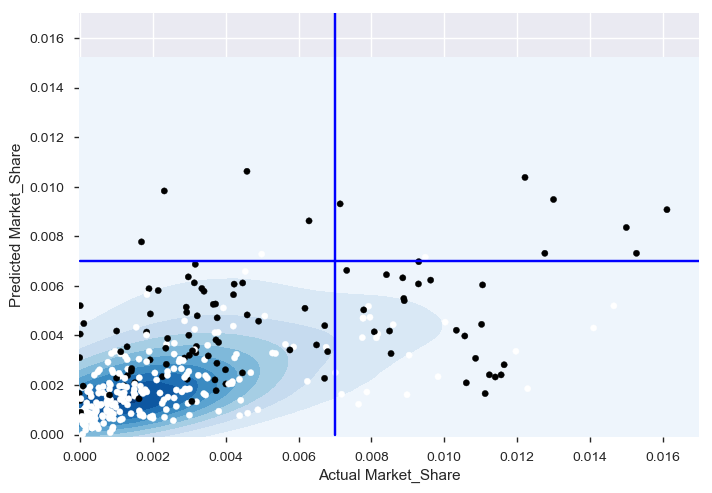

In [88]:
actual = cat_reg_test_actual
predicted = cat_reg_test_pred
pred_class = cat_clas_test_pred

size = 0.017

sns.kdeplot(actual, predicted, cmap="Blues", shade=True, shade_lowest=True)
df = pd.DataFrame({'Actual Market_Share':actual, 'Predicted Market_Share':predicted})
df.plot('Actual Market_Share', 'Predicted Market_Share', kind='scatter', ax=plt.gca(), color=pred_class)
plt.plot([0,np.max(actual)],[succesful_threshold,succesful_threshold],'b')
plt.plot([succesful_threshold,succesful_threshold],[0,np.max(actual)],'b')
plt.xlim([np.min(actual),size])
plt.ylim([np.min(predicted),size])

# 3. Predictions

Use the best model to predict on new data (score_data.xlsx)

In [89]:
new_preds_reg = np.expm1(cat_reg_model.predict(pred_pool_reg))/1000
new_preds_class = cat_clas_model.predict(pred_pool_reg)
new_preds_class_prob = cat_clas_model.predict_proba(pred_pool_reg)

What are the top 5 predictions for each model?

In [90]:
predicted = pd.concat([predict
           ,pd.Series(new_preds_reg).rename('predicted_market_share')
           ,pd.Series(new_preds_class).rename('predicted_successful')
           ,pd.Series(new_preds_class_prob[:,1]).rename('predicted_sucessful_probability')]
           ,axis=1)

relevant_columns = ['BRMID','MARKET', 'RETAILPACKPRICE', 'PCKT', 'PRICECLASS','predicted_market_share','predicted_successful','predicted_sucessful_probability']
predicted[relevant_columns].sort_values(by='predicted_market_share', ascending=False).head()

,BRMID,MARKET,RETAILPACKPRICE,PCKT,PRICECLASS,predicted_market_share,predicted_successful,predicted_sucessful_probability
28,60071997,MARKET30,2.00,PCKT11,PRICECLASS1,0.007424,1.0,0.946420
27,60080398,MARKET30,1.55,PCKT11,PRICECLASS16,0.007339,1.0,0.905673
19,60078078,MARKET89,10.00,PCKT24,PRICECLASS16,0.007185,1.0,0.936241
26,50063481,MARKET30,2.25,PCKT11,PRICECLASS16,0.006314,1.0,0.896555
18,60072876,MARKET89,10.00,PCKT24,PRICECLASS16,0.006262,1.0,0.942638


In [91]:
predicted[relevant_columns].sort_values(by='predicted_sucessful_probability', ascending=False).head()

,BRMID,MARKET,RETAILPACKPRICE,PCKT,PRICECLASS,predicted_market_share,predicted_successful,predicted_sucessful_probability
28,60071997,MARKET30,2.00,PCKT11,PRICECLASS1,0.007424,1.0,0.946420
18,60072876,MARKET89,10.00,PCKT24,PRICECLASS16,0.006262,1.0,0.942638
19,60078078,MARKET89,10.00,PCKT24,PRICECLASS16,0.007185,1.0,0.936241
27,60080398,MARKET30,1.55,PCKT11,PRICECLASS16,0.007339,1.0,0.905673
26,50063481,MARKET30,2.25,PCKT11,PRICECLASS16,0.006314,1.0,0.896555


### 3.2.1 How much both models agree to each other

(0, 1)

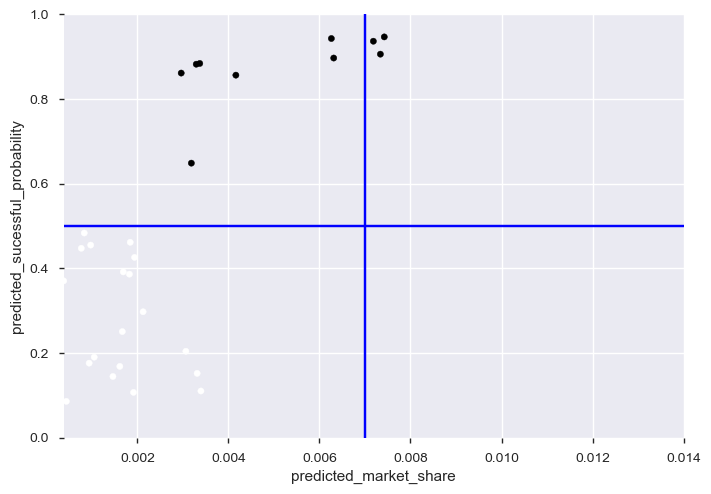

In [92]:
class_threshold = 0.5
reg_threshold = 0.007
size = 0.014

predicted.plot('predicted_market_share', 'predicted_sucessful_probability', kind='scatter', color=predicted['predicted_successful'])
plt.plot([0,size],[class_threshold,class_threshold],'b')
plt.plot([reg_threshold,reg_threshold],[0,1],'b')
plt.xlim([np.min(predicted['predicted_market_share']),size])
plt.ylim([0,1])

**Our predictions tells that 14 of those products will be successful**

In [93]:
predicted.groupby('predicted_successful').size()

predicted_successful
0.0    19
1.0    10
dtype: int64

** Some markets are predicted to be more successful**

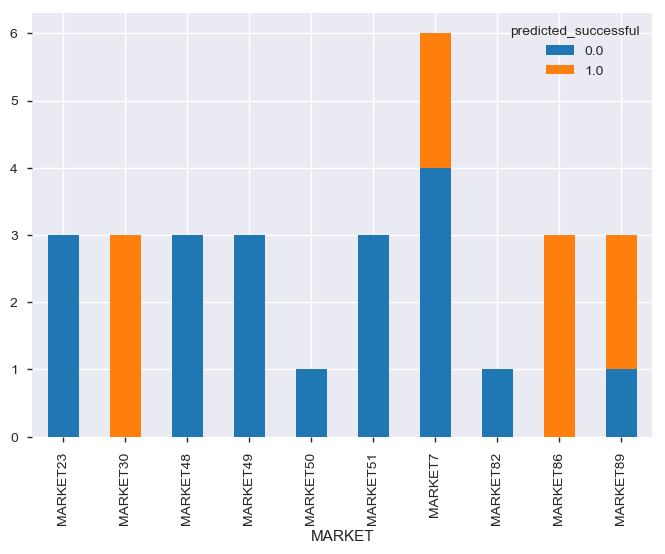

In [94]:
predicted.groupby(['MARKET','predicted_successful'])['MARKET'].count().unstack('predicted_successful').plot.bar(stacked=True)

** Some retail pack prices are predicted to be more successful**

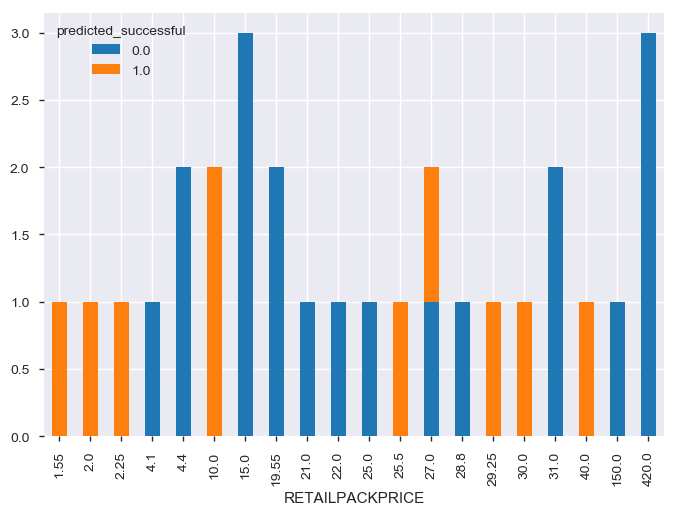

In [95]:
predicted.groupby(['RETAILPACKPRICE','predicted_successful'])['RETAILPACKPRICE'].count().unstack('predicted_successful').plot.bar(stacked=True)

** Some packets are predicted to be more successful**

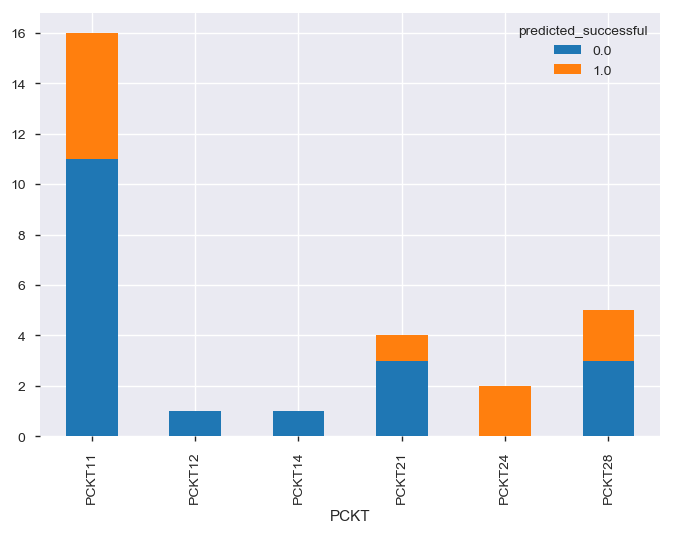

In [96]:
predicted.groupby(['PCKT','predicted_successful'])['PCKT'].count().unstack('predicted_successful').plot.bar(stacked=True)

**Safest predictions** 

In [97]:
predicted[(predicted['predicted_market_share'] > 0.007) & (predicted['predicted_sucessful_probability'] > 0.5)][relevant_columns]

,BRMID,MARKET,RETAILPACKPRICE,PCKT,PRICECLASS,predicted_market_share,predicted_successful,predicted_sucessful_probability
19,60078078,MARKET89,10.00,PCKT24,PRICECLASS16,0.007185,1.0,0.936241
27,60080398,MARKET30,1.55,PCKT11,PRICECLASS16,0.007339,1.0,0.905673
28,60071997,MARKET30,2.00,PCKT11,PRICECLASS1,0.007424,1.0,0.946420


**Complete list of predictions**

In [98]:
predicted[relevant_columns].sort_values(by='predicted_market_share', ascending=False)

,BRMID,MARKET,RETAILPACKPRICE,PCKT,PRICECLASS,predicted_market_share,predicted_successful,predicted_sucessful_probability
28,60071997,MARKET30,2.00,PCKT11,PRICECLASS1,0.007424,1.0,0.946420
27,60080398,MARKET30,1.55,PCKT11,PRICECLASS16,0.007339,1.0,0.905673
19,60078078,MARKET89,10.00,PCKT24,PRICECLASS16,0.007185,1.0,0.936241
26,50063481,MARKET30,2.25,PCKT11,PRICECLASS16,0.006314,1.0,0.896555
18,60072876,MARKET89,10.00,PCKT24,PRICECLASS16,0.006262,1.0,0.942638
11,60099682,MARKET86,40.00,PCKT21,PRICECLASS5,0.004165,1.0,0.856115
9,50064424,MARKET82,28.80,PCKT11,PRICECLASS22,0.003397,0.0,0.110328
3,60078732,MARKET7,29.25,PCKT11,PRICECLASS3,0.003371,1.0,0.883759
13,60044419,MARKET48,31.00,PCKT11,PRICECLASS16,0.003314,0.0,0.151954
2,60078730,MARKET7,27.00,PCKT11,PRICECLASS3,0.003294,1.0,0.881962
